# Lab 02: Conditional Flow Matching with sde_lib

This notebook demonstrates how to use the refactored `sde_lib` package to:
- Build conditional probability paths
- Train a flow model with Conditional Flow Matching (CFM)
- Train a score model with Conditional Score Matching (CSM)

In [29]:
# Setup and Imports
import torch
import matplotlib.pyplot as plt
from einops import repeat

from sde_lib import (
    # Distributions
    Gaussian, GaussianMixture,
    CirclesSampleable, CheckerboardSampleable, MoonsSampleable,
    # Schedules and Paths
    LinearAlpha, SquareRootBeta,
    GaussianConditionalProbabilityPath, LinearConditionalProbabilityPath,
    # Models and Trainers
    MLPVectorField, MLPScore, ScoreFromVectorField,
    ConditionalFlowMatchingTrainer, ConditionalScoreMatchingTrainer,
    # Processes
    ConditionalVectorFieldODE, LearnedVectorFieldODE, LangevinFlowSDE,
    # Simulators
    EulerSimulator, EulerMaruyamaSimulator,
    # Visualization
    hist2d_samples, imshow_density, get_trajectory_snapshot_indices
)

# Device configuration
if torch.accelerator.is_available():
    device = torch.accelerator.current_accelerator().type
else:
    device = "cpu"

print(f"Using device: {device}")

import sde_lib
print(f"SDE Library version: {sde_lib.__version__}")
print(f"Version info: {sde_lib.get_version_info()}")


Using device: mps
SDE Library version: 1.1.0
Version info: {'sde_lib_version': '1.1.0', 'torch_version': '2.8.0', 'cuda_available': False, 'mps_available': True}


## 1. Conditional Flow Matching (CFM) Quick Start

We learn a vector field $u_t^\theta(x)$ that matches the conditional reference field.

In [30]:
# Build a Gaussian conditional path
p_data = GaussianMixture.symmetric_2D(nmodes=5, std=1.0, scale=10.0).to(device)
path = GaussianConditionalProbabilityPath(
    p_data=p_data,
    alpha=LinearAlpha(),
    beta=SquareRootBeta(),
).to(device)

# Vector field model
flow_model = MLPVectorField(dim=2, hiddens=[64, 64, 64, 64]).to(device)

# Trainer
flow_trainer = ConditionalFlowMatchingTrainer(path=path, model=flow_model, device=device)

# Train (quick demo)
flow_losses = flow_trainer.train(num_epochs=5000, lr=1e-3, batch_size=4000)
print(f"Final CFM loss: {flow_losses[-1]:.4f}")

Epoch 4999, loss: 22.69617462158203: : 5000it [00:30, 163.61it/s] 


Final CFM loss: 22.6962


## 2. Visualize Conditional ODE Path

For a fixed conditioning variable $z$, visualize how $p_t(x|z)$ evolves through the conditional ODE.

Simulating: 100%|██████████| 999/999 [00:00<00:00, 11058.85it/s]


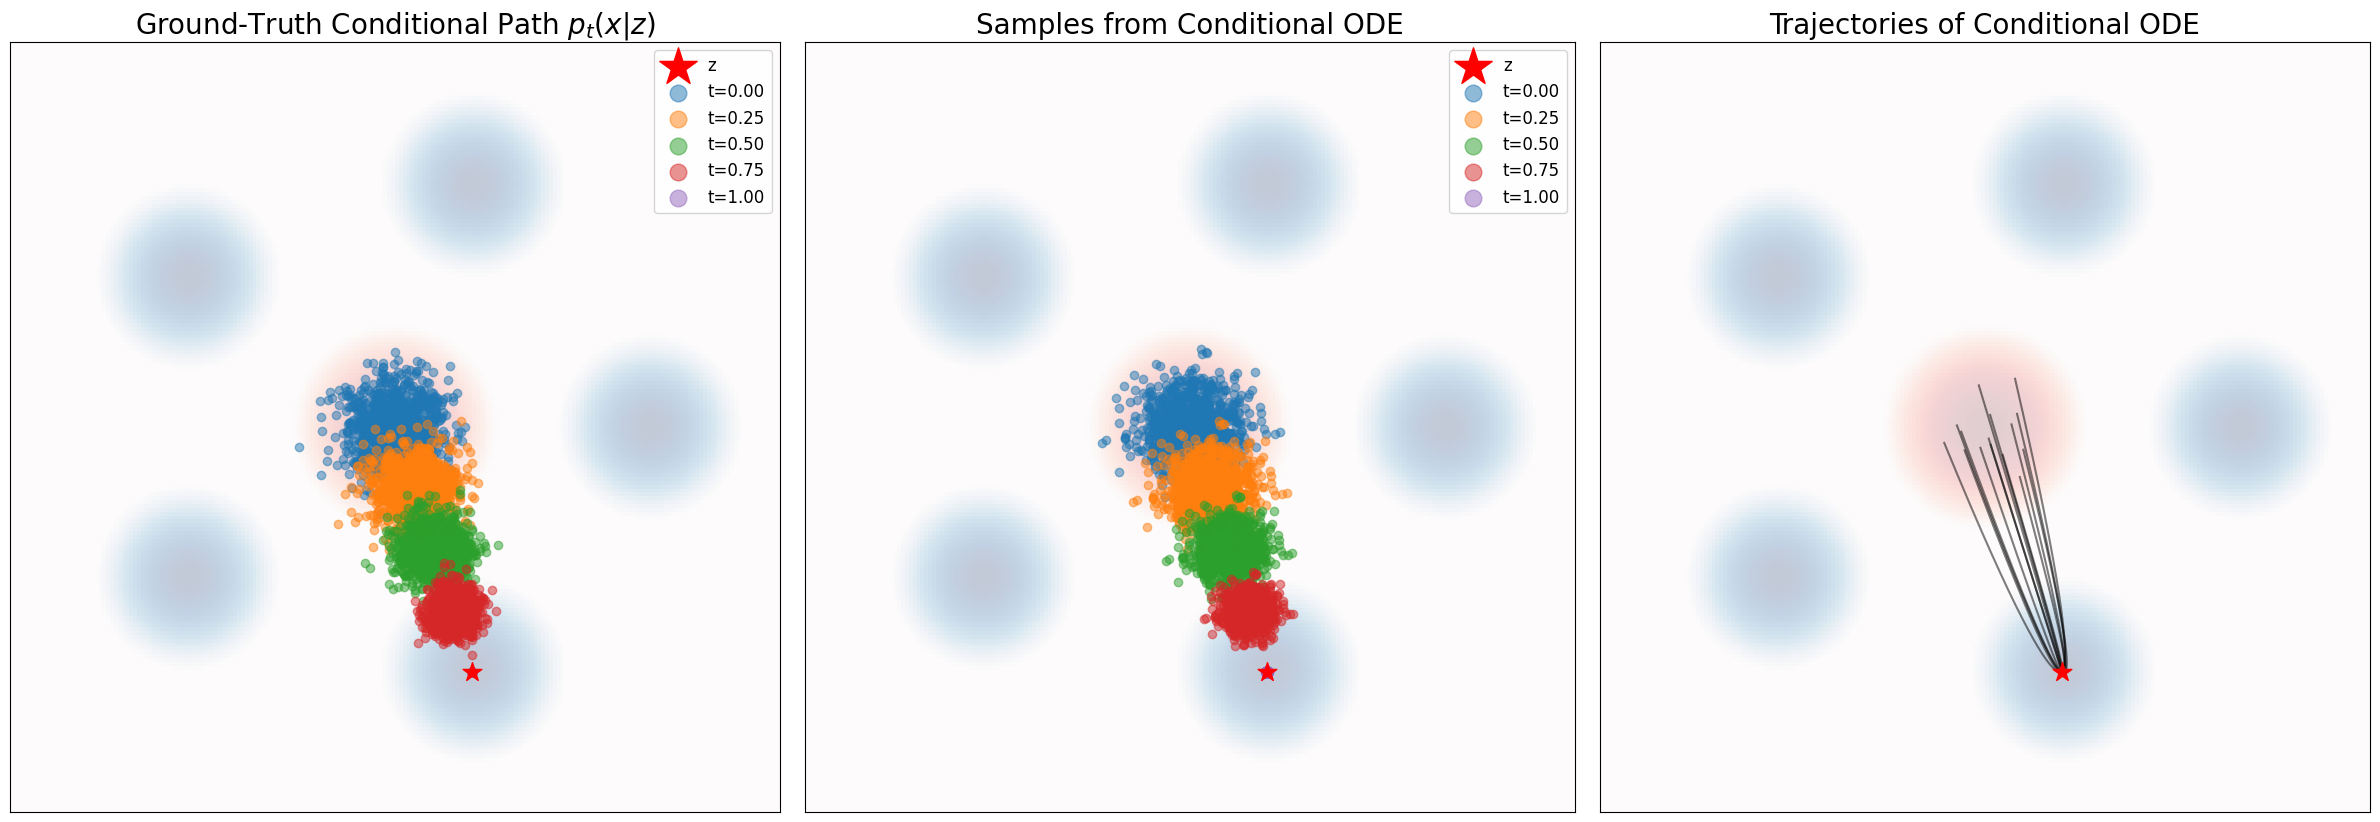

In [31]:
# Pick a conditioning variable z
torch.manual_seed(42)
z = path.sample_conditioning_variable(1)  # (1, 2)

# Create conditional ODE for this z
cond_ode = ConditionalVectorFieldODE(path, z)
simulator_cond = EulerSimulator(cond_ode)

# Simulate conditional path
num_samples_cond = 1000
num_timesteps_cond = 1000
x0_cond = path.p_simple.sample(num_samples_cond)
ts_cond = torch.linspace(0.0, 1.0, num_timesteps_cond, device=device)
traj_cond = simulator_cond.simulate_with_trajectory(x0_cond, ts_cond)

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
scale_cond = 15.0
indices_to_plot_cond = get_trajectory_snapshot_indices(num_timesteps_cond, num_timesteps_cond // 4)

# Panel 1: Ground-truth conditional samples
ax = axes[0]
ax.set_title('Ground-Truth Conditional Path $p_t(x|z)$', fontsize=20)
imshow_density(density=path.p_simple, bins=200, scale=scale_cond, device=device, ax=ax, vmin=-10, alpha=0.25, cmap='Reds')
imshow_density(density=p_data, bins=200, scale=scale_cond, device=device, ax=ax, vmin=-10, alpha=0.25, cmap='Blues')
ax.scatter(z[:, 0].cpu(), z[:, 1].cpu(), marker='*', color='red', s=200, label='z', zorder=20)
for idx in indices_to_plot_cond:
    t_val = ts_cond[idx]
    tt = repeat(t_val, ' -> b 1', b=num_samples_cond)
    zz = repeat(z, '1 d -> b d', b=num_samples_cond)
    samples = path.sample_conditional_path(zz, tt)
    ax.scatter(samples[:, 0].cpu(), samples[:, 1].cpu(), alpha=0.5, label=f't={t_val.item():.2f}')
ax.legend(prop={'size': 12}, markerscale=2)

# Panel 2: ODE samples
ax = axes[1]
ax.set_title('Samples from Conditional ODE', fontsize=20)
imshow_density(density=path.p_simple, bins=200, scale=scale_cond, device=device, ax=ax, vmin=-10, alpha=0.25, cmap='Reds')
imshow_density(density=p_data, bins=200, scale=scale_cond, device=device, ax=ax, vmin=-10, alpha=0.25, cmap='Blues')
ax.scatter(z[:, 0].cpu(), z[:, 1].cpu(), marker='*', color='red', s=200, label='z', zorder=20)
for idx in indices_to_plot_cond:
    t_val = ts_cond[idx]
    points = traj_cond[:, idx, :]
    ax.scatter(points[:, 0].cpu(), points[:, 1].cpu(), alpha=0.5, label=f't={t_val.item():.2f}')
ax.legend(prop={'size': 12}, markerscale=2)

# Panel 3: Trajectories
ax = axes[2]
ax.set_title('Trajectories of Conditional ODE', fontsize=20)
imshow_density(density=path.p_simple, bins=200, scale=scale_cond, device=device, ax=ax, vmin=-10, alpha=0.25, cmap='Reds')
imshow_density(density=p_data, bins=200, scale=scale_cond, device=device, ax=ax, vmin=-10, alpha=0.25, cmap='Blues')
ax.scatter(z[:, 0].cpu(), z[:, 1].cpu(), marker='*', color='red', s=200, label='z', zorder=20)
for traj_idx in range(15):
    ax.plot(traj_cond[traj_idx, :, 0].cpu(), traj_cond[traj_idx, :, 1].cpu(), alpha=0.5, color='black')

for ax in axes:
    ax.set_xlim(-scale_cond, scale_cond)
    ax.set_ylim(-scale_cond, scale_cond)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

## 3. Visualize Marginal ODE Path (Learned Flow)

Now visualize the learned marginal path using the trained flow model.

Simulating: 100%|██████████| 999/999 [00:00<00:00, 3107.78it/s]


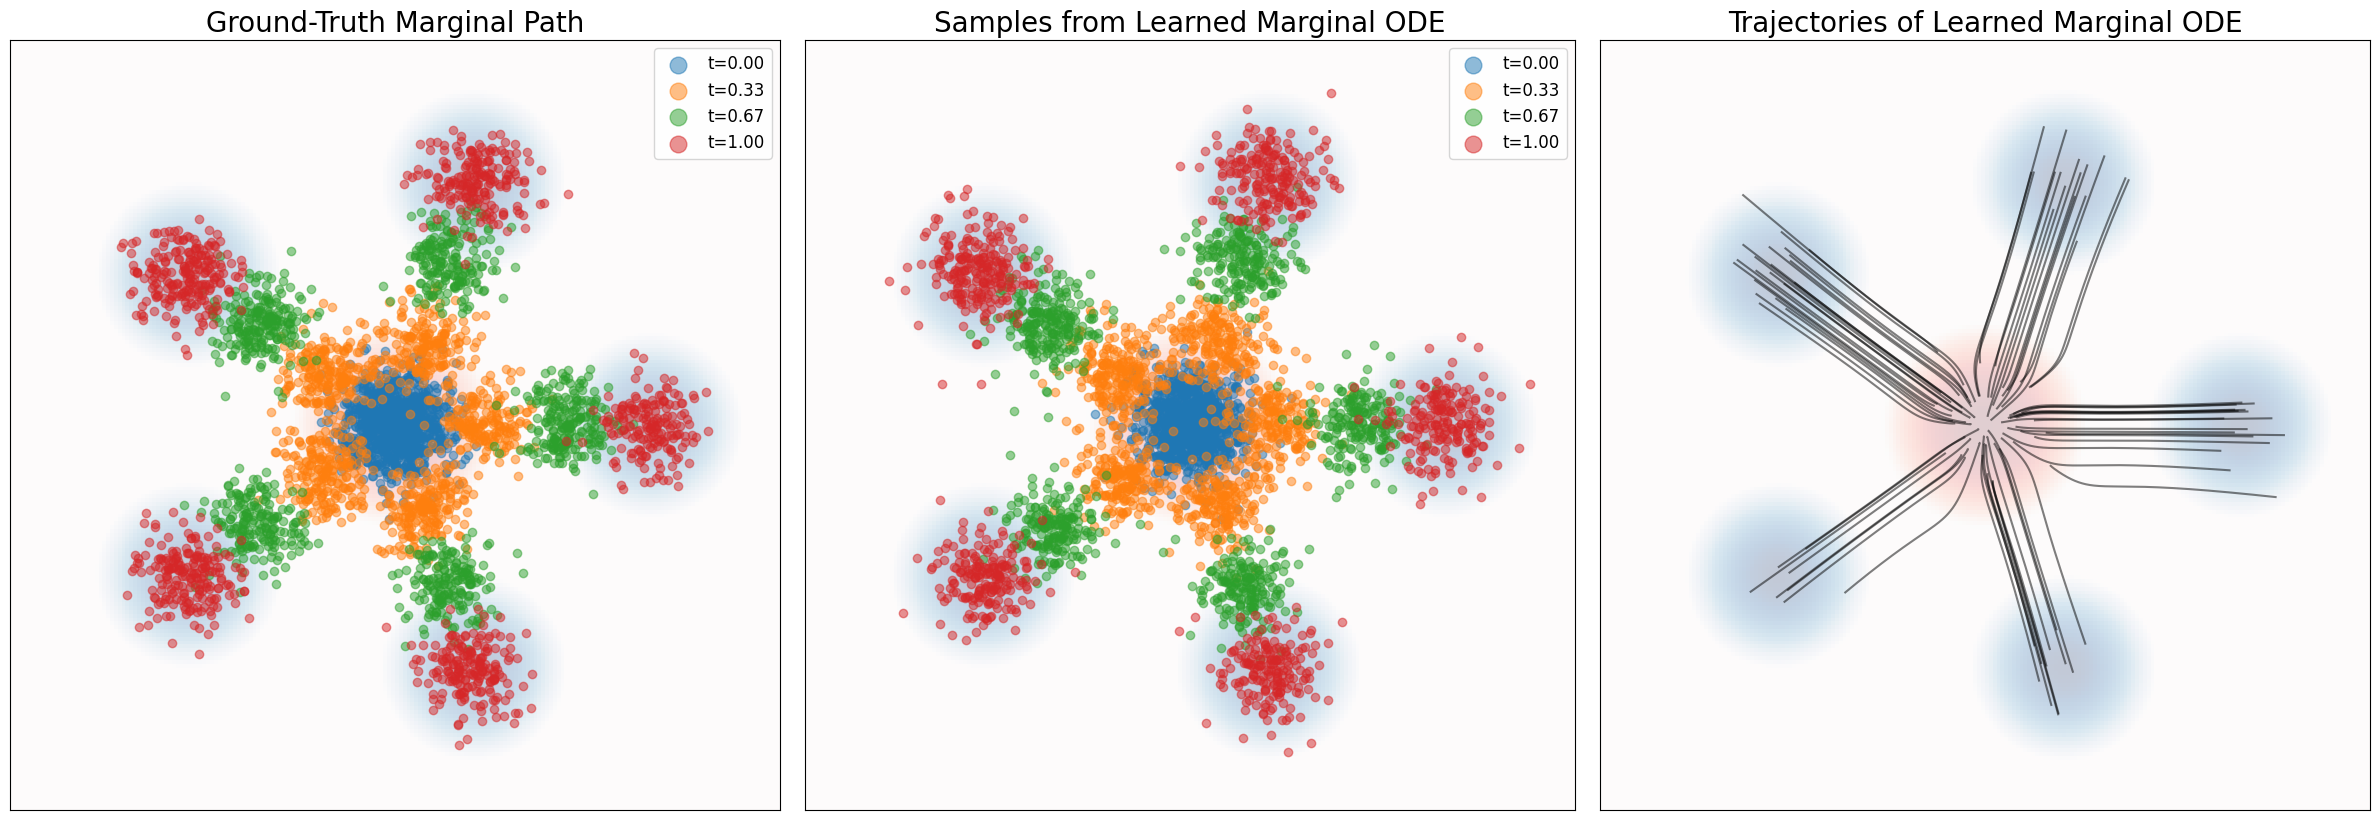

In [32]:
# Simulation parameters
num_samples = 1000
num_timesteps = 1000
num_marginals = 3
scale = 15.0
x_bounds = [-scale, scale]
y_bounds = [-scale, scale]

ode = LearnedVectorFieldODE(flow_model)
simulator = EulerSimulator(ode)

x0 = path.p_simple.sample(num_samples)
ts = torch.linspace(0.0, 1.0, num_timesteps, device=device)
traj_full = simulator.simulate_with_trajectory(x0, ts)  # (num_samples, num_timesteps, dim)

fig, axes = plt.subplots(1, 3, figsize=(24, 8))
indices_to_plot = get_trajectory_snapshot_indices(num_timesteps, num_timesteps // num_marginals)

# Ground truth
ax = axes[0]
ax.set_title("Ground-Truth Marginal Path", fontsize=20)
imshow_density(density=path.p_simple, bins=200, scale=scale, device=device, ax=ax, vmin=-10, alpha=0.25, cmap='Reds')
imshow_density(density=path.p_data, bins=200, scale=scale, device=device, ax=ax, vmin=-10, alpha=0.25, cmap='Blues')
for idx in indices_to_plot:
    t_val = ts[idx]
    tt = repeat(t_val, ' -> b 1', b=num_samples)
    marginal_samples = path.sample_marginal_path(tt)
    ax.scatter(marginal_samples[:, 0].cpu(), marginal_samples[:, 1].cpu(), alpha=0.5, label=f't={t_val.item():.2f}')
ax.legend(prop={'size': 12}, markerscale=2)

# Learned samples
ax = axes[1]
ax.set_title("Samples from Learned Marginal ODE", fontsize=20)
imshow_density(density=path.p_simple, bins=200, scale=scale, device=device, ax=ax, vmin=-10, alpha=0.25, cmap='Reds')
imshow_density(density=path.p_data, bins=200, scale=scale, device=device, ax=ax, vmin=-10, alpha=0.25, cmap='Blues')
for idx in indices_to_plot:
    t_val = ts[idx]
    points = traj_full[:, idx, :]
    ax.scatter(points[:, 0].cpu(), points[:, 1].cpu(), alpha=0.5, label=f't={t_val.item():.2f}')
ax.legend(prop={'size': 12}, markerscale=2)

# Trajectories
ax = axes[2]
ax.set_title("Trajectories of Learned Marginal ODE", fontsize=20)
imshow_density(density=path.p_simple, bins=200, scale=scale, device=device, ax=ax, vmin=-10, alpha=0.25, cmap='Reds')
imshow_density(density=path.p_data, bins=200, scale=scale, device=device, ax=ax, vmin=-10, alpha=0.25, cmap='Blues')
for traj_idx in range(75):
    ax.plot(traj_full[traj_idx, :, 0].cpu(), traj_full[traj_idx, :, 1].cpu(), alpha=0.5, color='black')

for ax in axes:
    ax.set_xlim(*x_bounds)
    ax.set_ylim(*y_bounds)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

## 4. Train Score Model with Conditional Score Matching (CSM)

We learn a score model $s_t^\theta(x)$ that matches the conditional score $\nabla \log p_t(x|z)$.

In [24]:
# Score model
score_model = MLPScore(dim=2, hiddens=[64, 64, 64, 64]).to(device)

# Trainer
score_trainer = ConditionalScoreMatchingTrainer(path=path, model=score_model, device=device)

# Train (quick demo)
score_losses = score_trainer.train(num_epochs=5000, lr=1e-3, batch_size=4000)
print(f"Final CSM loss: {score_losses[-1]:.4f}")

Epoch 4999, loss: 12.619367599487305: : 5000it [00:29, 167.07it/s]

Final CSM loss: 12.6194


## 5. Visualize Conditional SDE Path

Add diffusion to the conditional ODE using the ground-truth score: $dX_t = [u_t(x|z) + \frac{1}{2}\sigma^2 \nabla \log p_t(x|z)]dt + \sigma dW_t$

Simulating: 100%|██████████| 999/999 [00:00<00:00, 1393.71it/s]


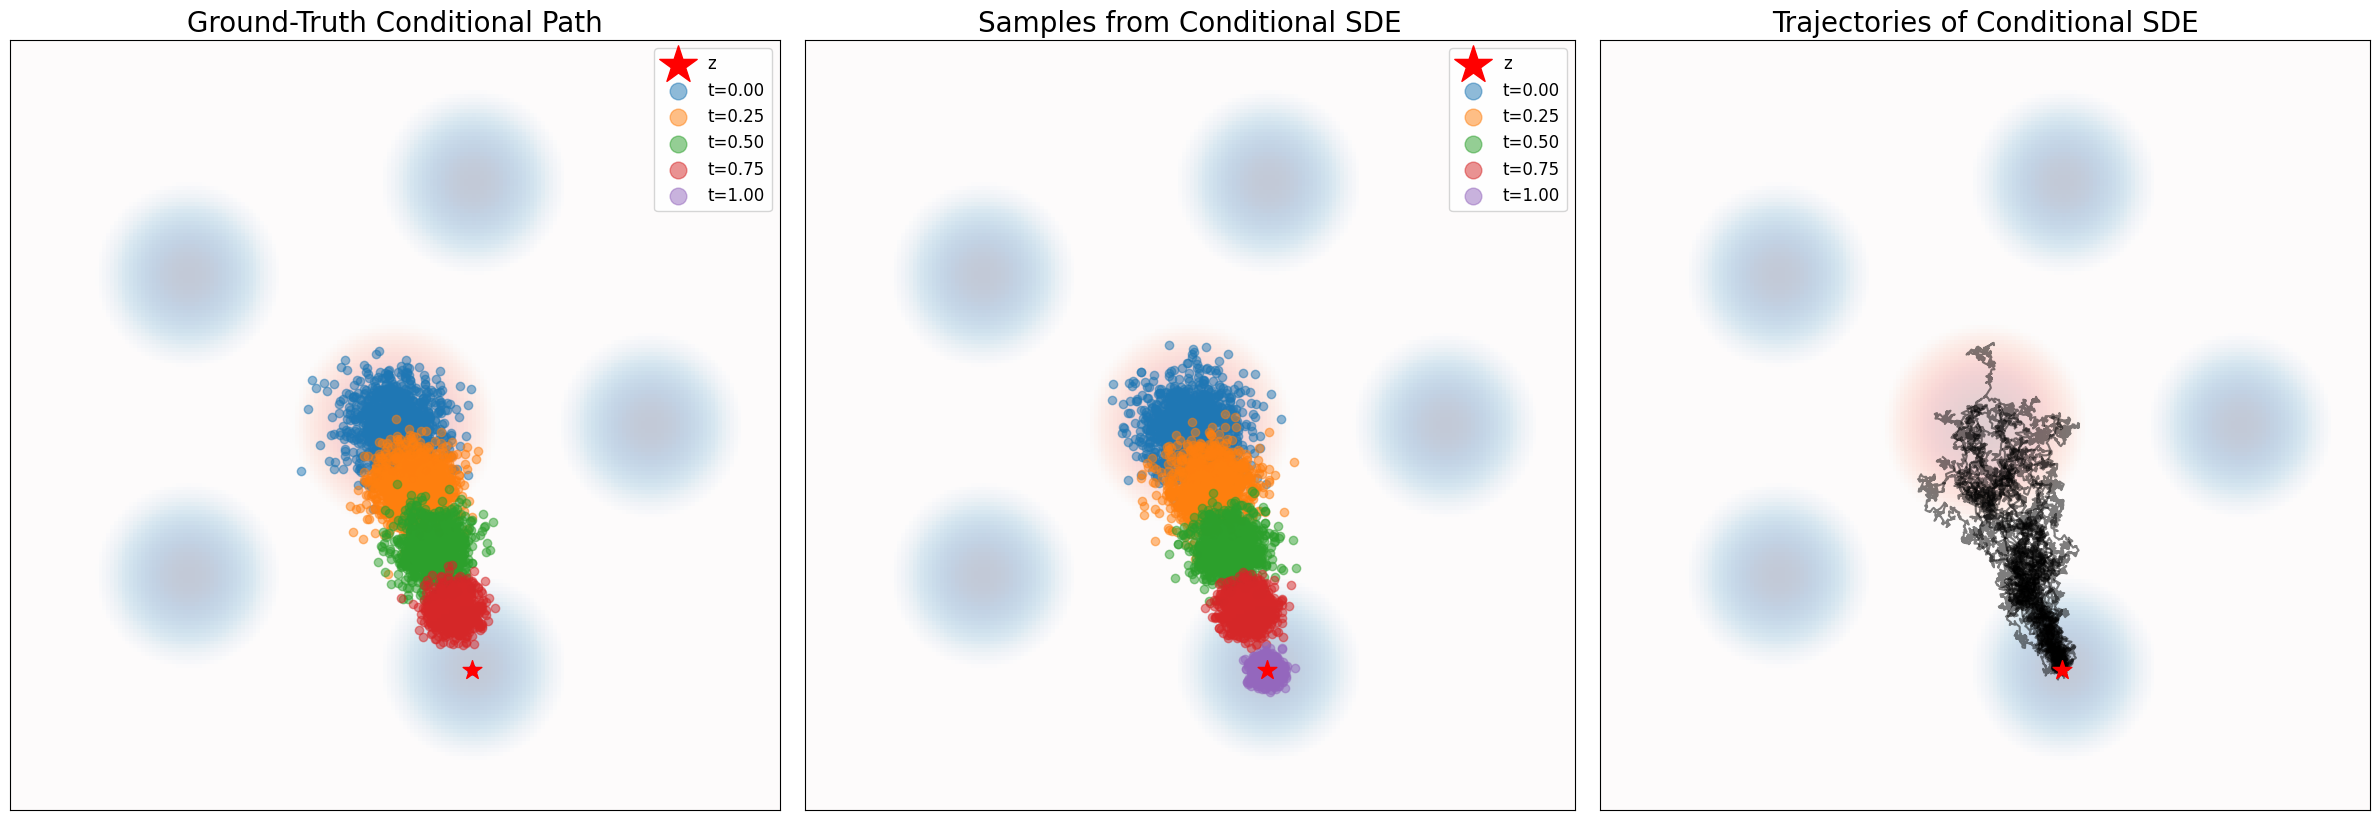

In [33]:
from sde_lib import ConditionalVectorFieldSDE

# Use the same z from conditional ODE
sigma_cond = 2.5
cond_sde = ConditionalVectorFieldSDE(path, z, sigma=sigma_cond)
simulator_cond_sde = EulerMaruyamaSimulator(cond_sde)

# Simulate
num_samples_sde = 1000
num_timesteps_sde = 1000
x0_sde = path.p_simple.sample(num_samples_sde)
ts_sde = torch.linspace(0.0, 1.0, num_timesteps_sde, device=device)
traj_sde = simulator_cond_sde.simulate_with_trajectory(x0_sde, ts_sde)

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
indices_sde = get_trajectory_snapshot_indices(num_timesteps_sde, num_timesteps_sde // 4)

# Ground truth conditional samples
ax = axes[0]
ax.set_title('Ground-Truth Conditional Path', fontsize=20)
imshow_density(density=path.p_simple, bins=200, scale=scale_cond, device=device, ax=ax, vmin=-10, alpha=0.25, cmap='Reds')
imshow_density(density=p_data, bins=200, scale=scale_cond, device=device, ax=ax, vmin=-10, alpha=0.25, cmap='Blues')
ax.scatter(z[:, 0].cpu(), z[:, 1].cpu(), marker='*', color='red', s=200, label='z', zorder=20)
for idx in indices_sde:
    t_val = ts_sde[idx]
    tt = repeat(t_val, ' -> b 1', b=num_samples_sde)
    zz = repeat(z, '1 d -> b d', b=num_samples_sde)
    marginal_samples = path.sample_conditional_path(zz, tt)
    ax.scatter(marginal_samples[:, 0].cpu(), marginal_samples[:, 1].cpu(), alpha=0.5, label=f't={t_val.item():.2f}')
ax.legend(prop={'size': 12}, markerscale=2)

# SDE samples
ax = axes[1]
ax.set_title('Samples from Conditional SDE', fontsize=20)
imshow_density(density=path.p_simple, bins=200, scale=scale_cond, device=device, ax=ax, vmin=-10, alpha=0.25, cmap='Reds')
imshow_density(density=p_data, bins=200, scale=scale_cond, device=device, ax=ax, vmin=-10, alpha=0.25, cmap='Blues')
ax.scatter(z[:, 0].cpu(), z[:, 1].cpu(), marker='*', color='red', s=200, label='z', zorder=20)
for idx in indices_sde:
    t_val = ts_sde[idx]
    points = traj_sde[:, idx, :]
    ax.scatter(points[:, 0].cpu(), points[:, 1].cpu(), alpha=0.5, label=f't={t_val.item():.2f}')
ax.legend(prop={'size': 12}, markerscale=2)

# Trajectories
ax = axes[2]
ax.set_title('Trajectories of Conditional SDE', fontsize=20)
imshow_density(density=path.p_simple, bins=200, scale=scale_cond, device=device, ax=ax, vmin=-10, alpha=0.25, cmap='Reds')
imshow_density(density=p_data, bins=200, scale=scale_cond, device=device, ax=ax, vmin=-10, alpha=0.25, cmap='Blues')
ax.scatter(z[:, 0].cpu(), z[:, 1].cpu(), marker='*', color='red', s=200, label='z', zorder=20)
for traj_idx in range(15):
    ax.plot(traj_sde[traj_idx, :, 0].cpu(), traj_sde[traj_idx, :, 1].cpu(), alpha=0.5, color='black')

for ax in axes:
    ax.set_xlim(-scale_cond, scale_cond)
    ax.set_ylim(-scale_cond, scale_cond)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

## 6. Visualize Marginal SDE Path (Langevin Flow)

Combine the learned flow and score models in an SDE: $dX_t = [u_t^\theta(x) + \frac{1}{2}\sigma^2 s_t^\theta(x)]dt + \sigma dW_t$

Simulating: 100%|██████████| 299/299 [00:00<00:00, 749.94it/s]


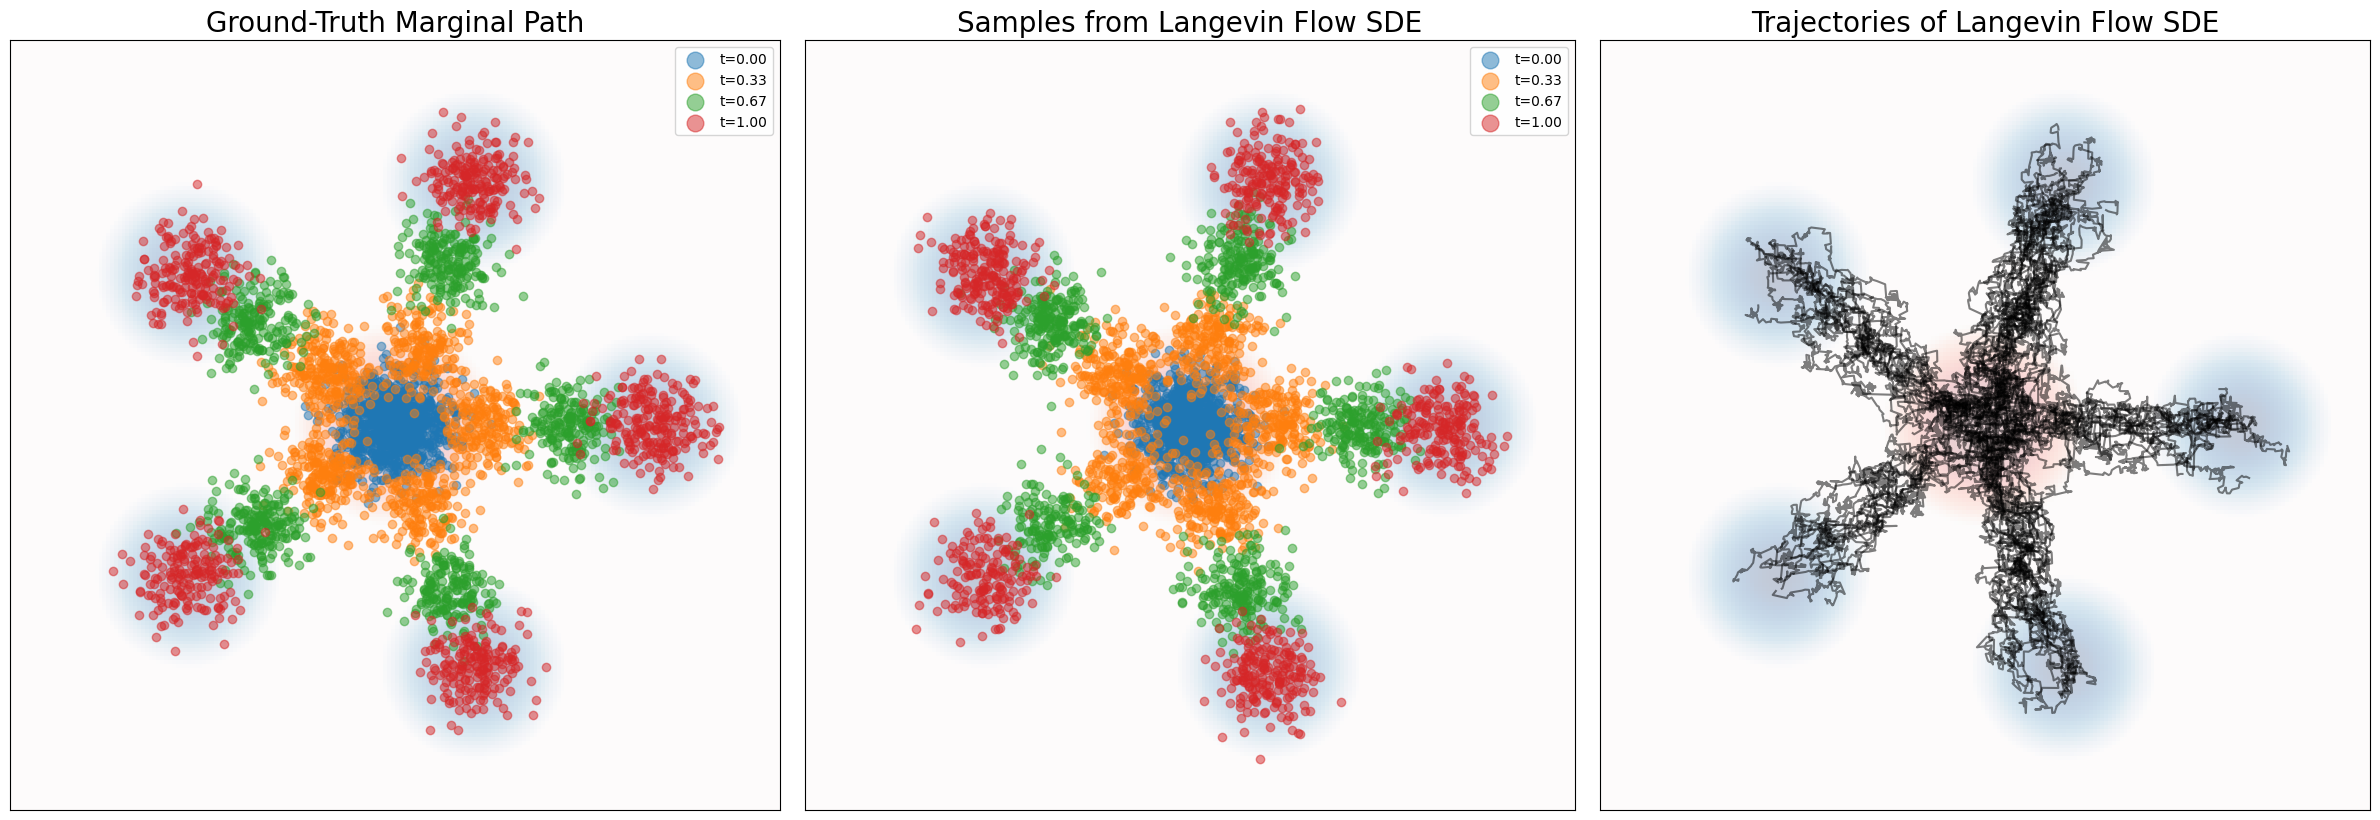

In [34]:
# Create SDE combining flow + score
sigma_langevin = 2.0
langevin_sde = LangevinFlowSDE(flow_model, score_model, sigma=sigma_langevin)
langevin_simulator = EulerMaruyamaSimulator(langevin_sde)

# Simulate
num_samples_langevin = 1000
num_timesteps_langevin = 300
num_marginals_langevin = 3

x0_langevin = path.p_simple.sample(num_samples_langevin)
ts_langevin = torch.linspace(0.0, 1.0, num_timesteps_langevin, device=device)
traj_langevin = langevin_simulator.simulate_with_trajectory(x0_langevin, ts_langevin)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
indices_langevin = get_trajectory_snapshot_indices(num_timesteps_langevin, num_timesteps_langevin // num_marginals_langevin)
scale_langevin = 15.0

# Ground truth
ax = axes[0]
ax.set_title("Ground-Truth Marginal Path", fontsize=20)
imshow_density(density=path.p_simple, bins=200, scale=scale_langevin, device=device, ax=ax, vmin=-10, alpha=0.25, cmap='Reds')
imshow_density(density=path.p_data, bins=200, scale=scale_langevin, device=device, ax=ax, vmin=-10, alpha=0.25, cmap='Blues')
for idx in indices_langevin:
    t_val = ts_langevin[idx]
    tt = repeat(t_val, ' -> b 1', b=num_samples_langevin)
    marginal_samples = path.sample_marginal_path(tt)
    ax.scatter(marginal_samples[:, 0].cpu(), marginal_samples[:, 1].cpu(), alpha=0.5, label=f't={t_val.item():.2f}')
ax.legend(markerscale=2)

# SDE samples
ax = axes[1]
ax.set_title("Samples from Langevin Flow SDE", fontsize=20)
imshow_density(density=path.p_simple, bins=200, scale=scale_langevin, device=device, ax=ax, vmin=-10, alpha=0.25, cmap='Reds')
imshow_density(density=path.p_data, bins=200, scale=scale_langevin, device=device, ax=ax, vmin=-10, alpha=0.25, cmap='Blues')
for idx in indices_langevin:
    t_val = ts_langevin[idx]
    points = traj_langevin[:, idx, :]
    ax.scatter(points[:, 0].cpu(), points[:, 1].cpu(), alpha=0.5, label=f't={t_val.item():.2f}')
ax.legend(markerscale=2)

# Trajectories
ax = axes[2]
ax.set_title("Trajectories of Langevin Flow SDE", fontsize=20)
imshow_density(density=path.p_simple, bins=200, scale=scale_langevin, device=device, ax=ax, vmin=-10, alpha=0.25, cmap='Reds')
imshow_density(density=path.p_data, bins=200, scale=scale_langevin, device=device, ax=ax, vmin=-10, alpha=0.25, cmap='Blues')
for traj_idx in range(75):
    ax.plot(traj_langevin[traj_idx, :, 0].cpu(), traj_langevin[traj_idx, :, 1].cpu(), alpha=0.5, color='black')

for ax in axes:
    ax.set_xlim(-scale_langevin, scale_langevin)
    ax.set_ylim(-scale_langevin, scale_langevin)
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

## 7. ScoreFromVectorField: Derive Score from Flow

Compare scores derived from the vector field with directly learned scores.

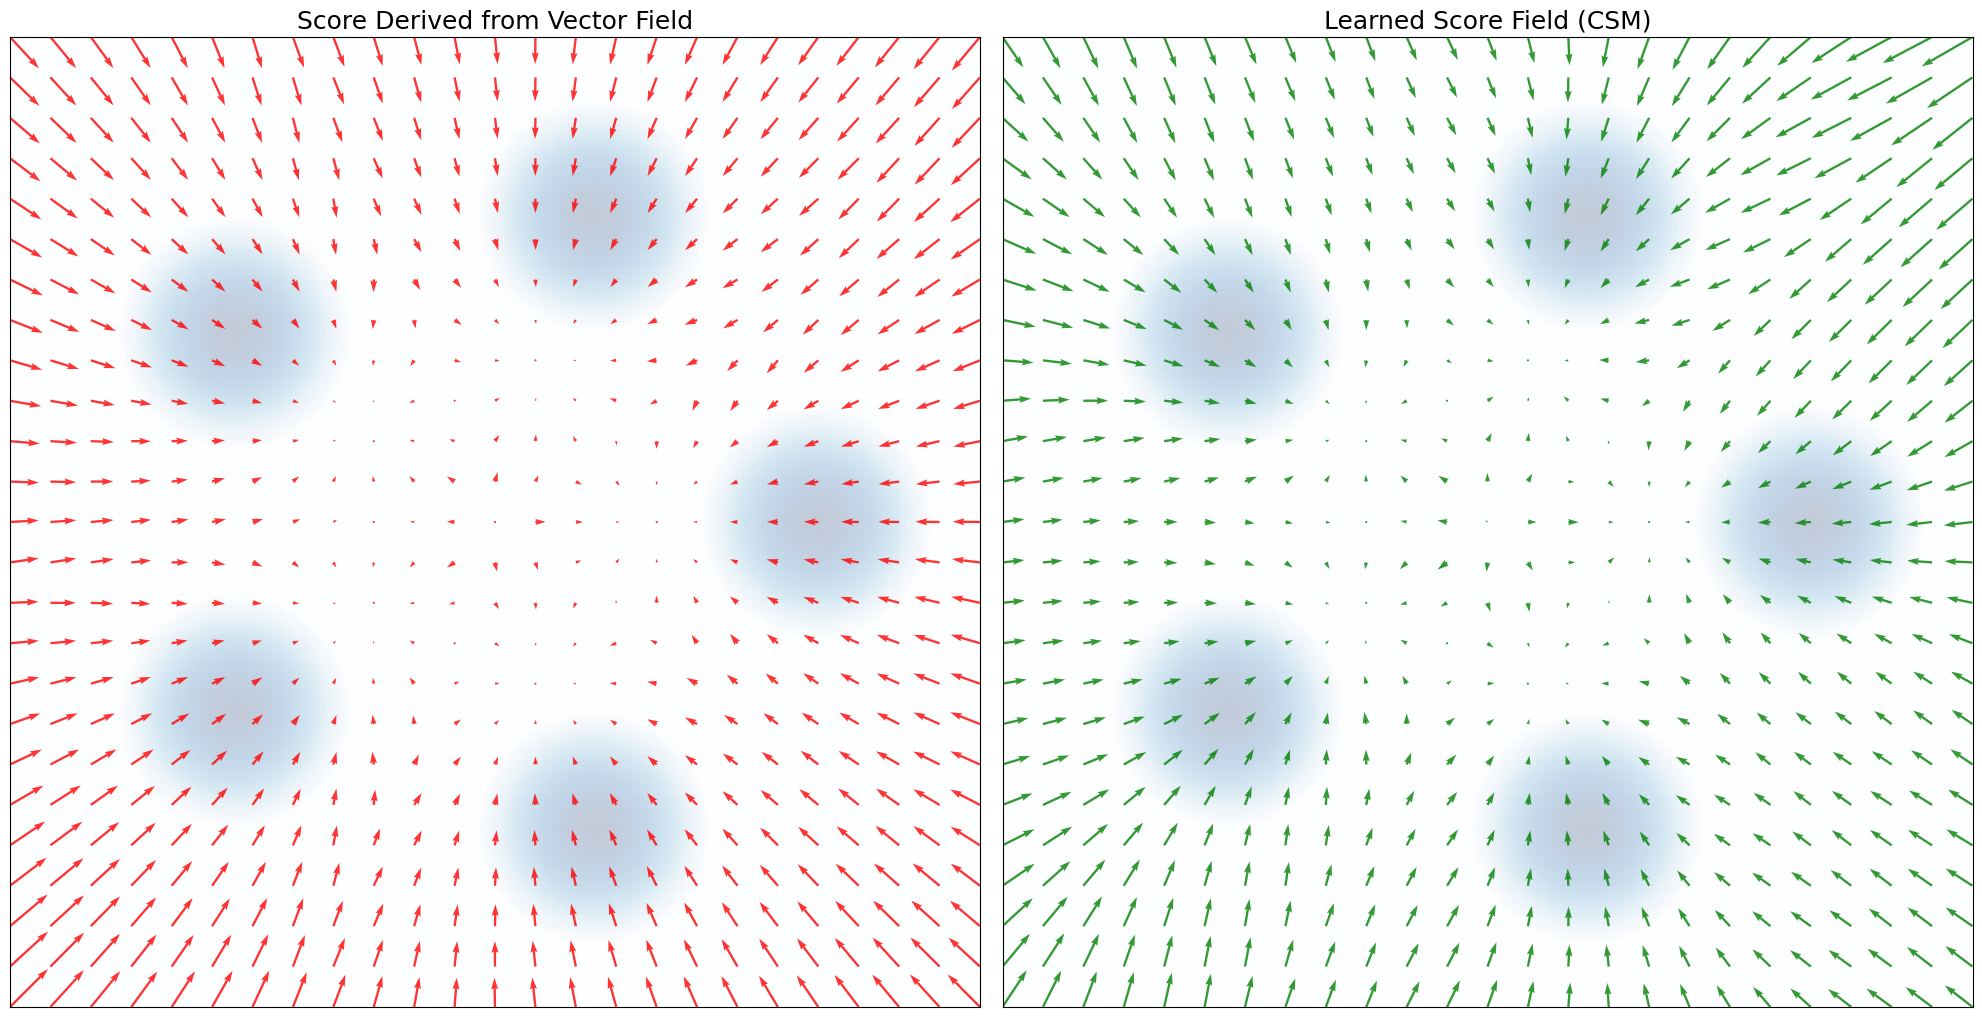

In [35]:
# Create a grid for evaluation
scale_score = 15.0
grid_size = 25
x_coords = torch.linspace(-scale_score, scale_score, grid_size, device=device)
y_coords = torch.linspace(-scale_score, scale_score, grid_size, device=device)
X, Y = torch.meshgrid(x_coords, y_coords, indexing='xy')
xy_grid = torch.stack([X.flatten(), Y.flatten()], dim=-1)  # (grid_size^2, 2)

# Evaluate at t=0.5
t_eval = torch.full((xy_grid.shape[0], 1), 0.5, device=device)

# Get learned scores (directly trained)
learned_scores = score_model(xy_grid, t_eval)
learned_scores_x = learned_scores[:, 0].reshape(grid_size, grid_size)
learned_scores_y = learned_scores[:, 1].reshape(grid_size, grid_size)

# Get scores derived from flow model
flow_score_model = ScoreFromVectorField(flow_model, path.alpha, path.beta)
flow_scores = flow_score_model(xy_grid, t_eval)
flow_scores_x = flow_scores[:, 0].reshape(grid_size, grid_size)
flow_scores_y = flow_scores[:, 1].reshape(grid_size, grid_size)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

ax = axes[0]
ax.set_title('Score Derived from Vector Field', fontsize=18)
imshow_density(density=p_data, bins=200, scale=scale_score, device=device, ax=ax, vmin=-10, alpha=0.25, cmap='Blues')
ax.quiver(X.detach().cpu(), Y.detach().cpu(), flow_scores_x.detach().cpu(), flow_scores_y.detach().cpu(), alpha=0.8, color='red')
ax.set_xlim(-scale_score, scale_score)
ax.set_ylim(-scale_score, scale_score)
ax.set_xticks([])
ax.set_yticks([])

ax = axes[1]
ax.set_title('Learned Score Field (CSM)', fontsize=18)
imshow_density(density=p_data, bins=200, scale=scale_score, device=device, ax=ax, vmin=-10, alpha=0.25, cmap='Blues')
ax.quiver(X.detach().cpu(), Y.detach().cpu(), learned_scores_x.detach().cpu(), learned_scores_y.detach().cpu(), alpha=0.8, color='green')
ax.set_xlim(-scale_score, scale_score)
ax.set_ylim(-scale_score, scale_score)
ax.set_xticks([])
ax.set_yticks([])

plt.tight_layout()
plt.show()

## 8. Linear Conditional Probability Path

The linear path $X_t = (1-t)X_0 + tz$ provides a simpler alternative. Let's train on Gaussian → Checkerboard.

In [19]:
# Build linear path
linear_path = LinearConditionalProbabilityPath(
    p_simple=Gaussian.isotropic(dim=2, std=1.0).to(device),
    p_data=CheckerboardSampleable(device, grid_size=4)
).to(device)

# Train flow model
linear_flow_model = MLPVectorField(dim=2, hiddens=[64, 64, 64, 64]).to(device)
linear_trainer = ConditionalFlowMatchingTrainer(path=linear_path, model=linear_flow_model, device=device)
linear_losses = linear_trainer.train(num_epochs=10000, lr=1e-3, batch_size=8000)
print(f"Final Linear CFM loss: {linear_losses[-1]:.4f}")

Epoch 9999, loss: 8.39909839630127: : 10000it [02:17, 72.81it/s] 

Final Linear CFM loss: 8.3991


Simulating: 100%|██████████| 99/99 [00:00<00:00, 235.40it/s]


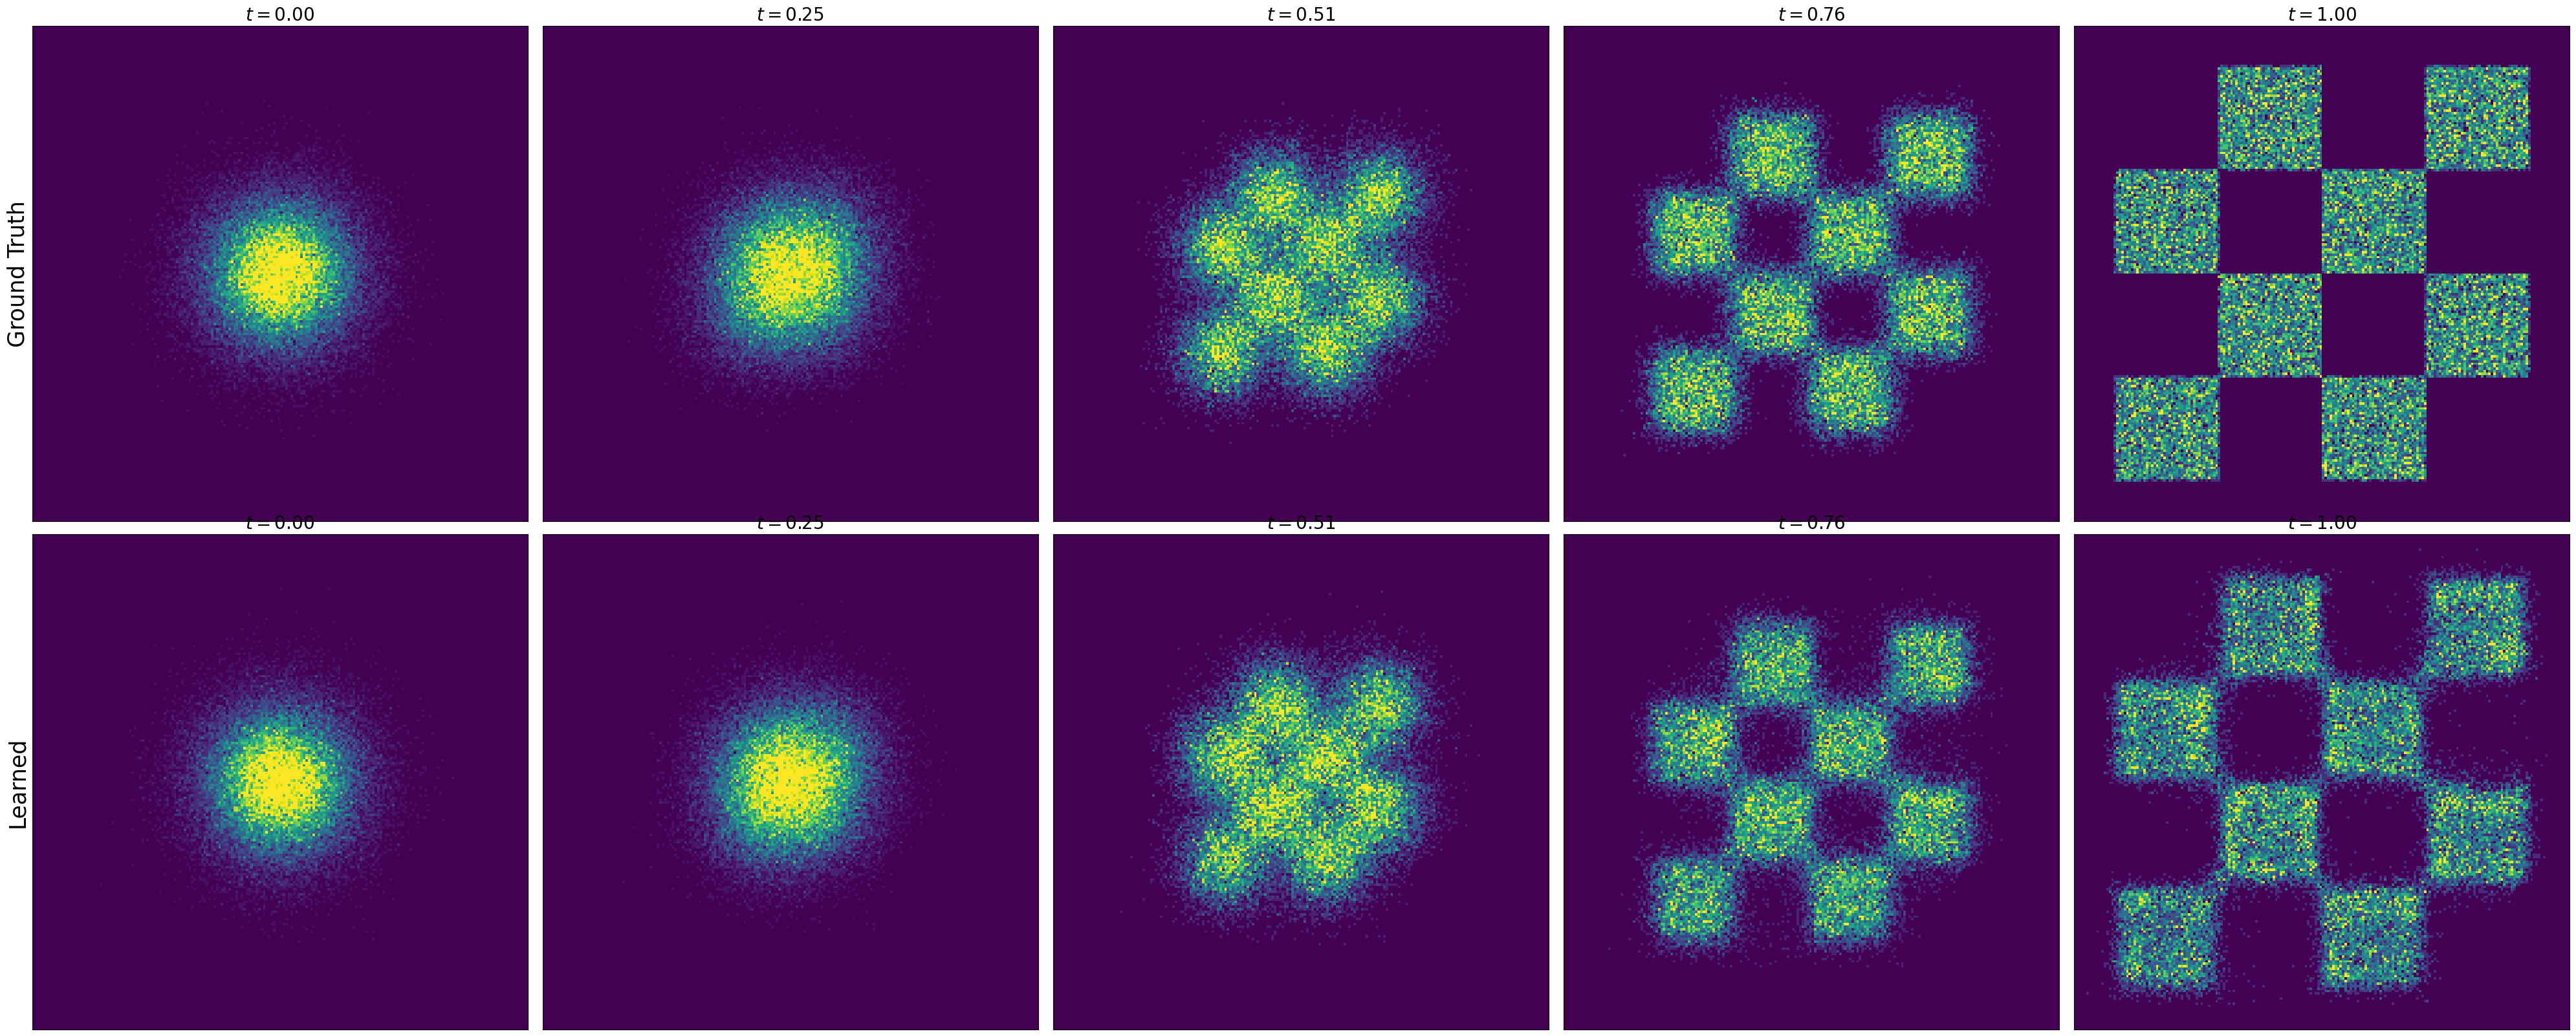

In [20]:
# Visualize learned marginal path
num_samples_linear = 50000
num_timesteps_linear = 100
num_marginals_linear = 5
scale_linear = 6.0

linear_ode = LearnedVectorFieldODE(linear_flow_model)
linear_simulator = EulerSimulator(linear_ode)

x0_linear = linear_path.p_simple.sample(num_samples_linear)
ts_linear = torch.linspace(0.0, 1.0, num_timesteps_linear, device=device)
traj_linear = linear_simulator.simulate_with_trajectory(x0_linear, ts_linear)

fig, axes = plt.subplots(2, num_marginals_linear, figsize=(8 * num_marginals_linear, 16))
indices_linear = get_trajectory_snapshot_indices(num_timesteps_linear, num_timesteps_linear // (num_marginals_linear - 1))

# Ground truth
axes[0, 0].set_ylabel("Ground Truth", fontsize=25)
for idx, time_idx in enumerate(indices_linear):
    t_val = ts_linear[time_idx]
    tt = repeat(t_val, ' -> b 1', b=num_samples_linear)
    marginal_samples = linear_path.sample_marginal_path(tt)
    ax = axes[0, idx]
    hist2d_samples(samples=marginal_samples.cpu(), ax=ax, bins=200, scale=scale_linear, percentile=99, alpha=1.0)
    ax.set_xlim(-scale_linear, scale_linear)
    ax.set_ylim(-scale_linear, scale_linear)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'$t={t_val.item():.2f}$', fontsize=20)

# Learned
axes[1, 0].set_ylabel("Learned", fontsize=25)
for idx, time_idx in enumerate(indices_linear):
    t_val = ts_linear[time_idx]
    points = traj_linear[:, time_idx, :]
    ax = axes[1, idx]
    hist2d_samples(samples=points.cpu(), ax=ax, bins=200, scale=scale_linear, percentile=99, alpha=1.0)
    ax.set_xlim(-scale_linear, scale_linear)
    ax.set_ylim(-scale_linear, scale_linear)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'$t={t_val.item():.2f}$', fontsize=20)

plt.tight_layout()
plt.show()

## 9. Bridging Experiment: Circles → Checkerboard

An impressive demonstration: transform one complex distribution into another!

In [21]:
# Build bridging path
bridging_path = LinearConditionalProbabilityPath(
    p_simple=CirclesSampleable(device=device),
    p_data=CheckerboardSampleable(device=device, grid_size=4)
).to(device)

# Train with larger model
bridging_model = MLPVectorField(dim=2, hiddens=[100, 100, 100, 100]).to(device)
bridging_trainer = ConditionalFlowMatchingTrainer(path=bridging_path, model=bridging_model, device=device)
bridging_losses = bridging_trainer.train(num_epochs=20000, lr=1e-3, batch_size=8000)
print(f"Final Bridging CFM loss: {bridging_losses[-1]:.4f}")

0it [00:00, ?it/s]

Epoch 19999, loss: 22.175281524658203: : 20000it [06:28, 51.48it/s]


Final Bridging CFM loss: 22.1753


Simulating: 100%|██████████| 199/199 [00:00<00:00, 542.31it/s] 


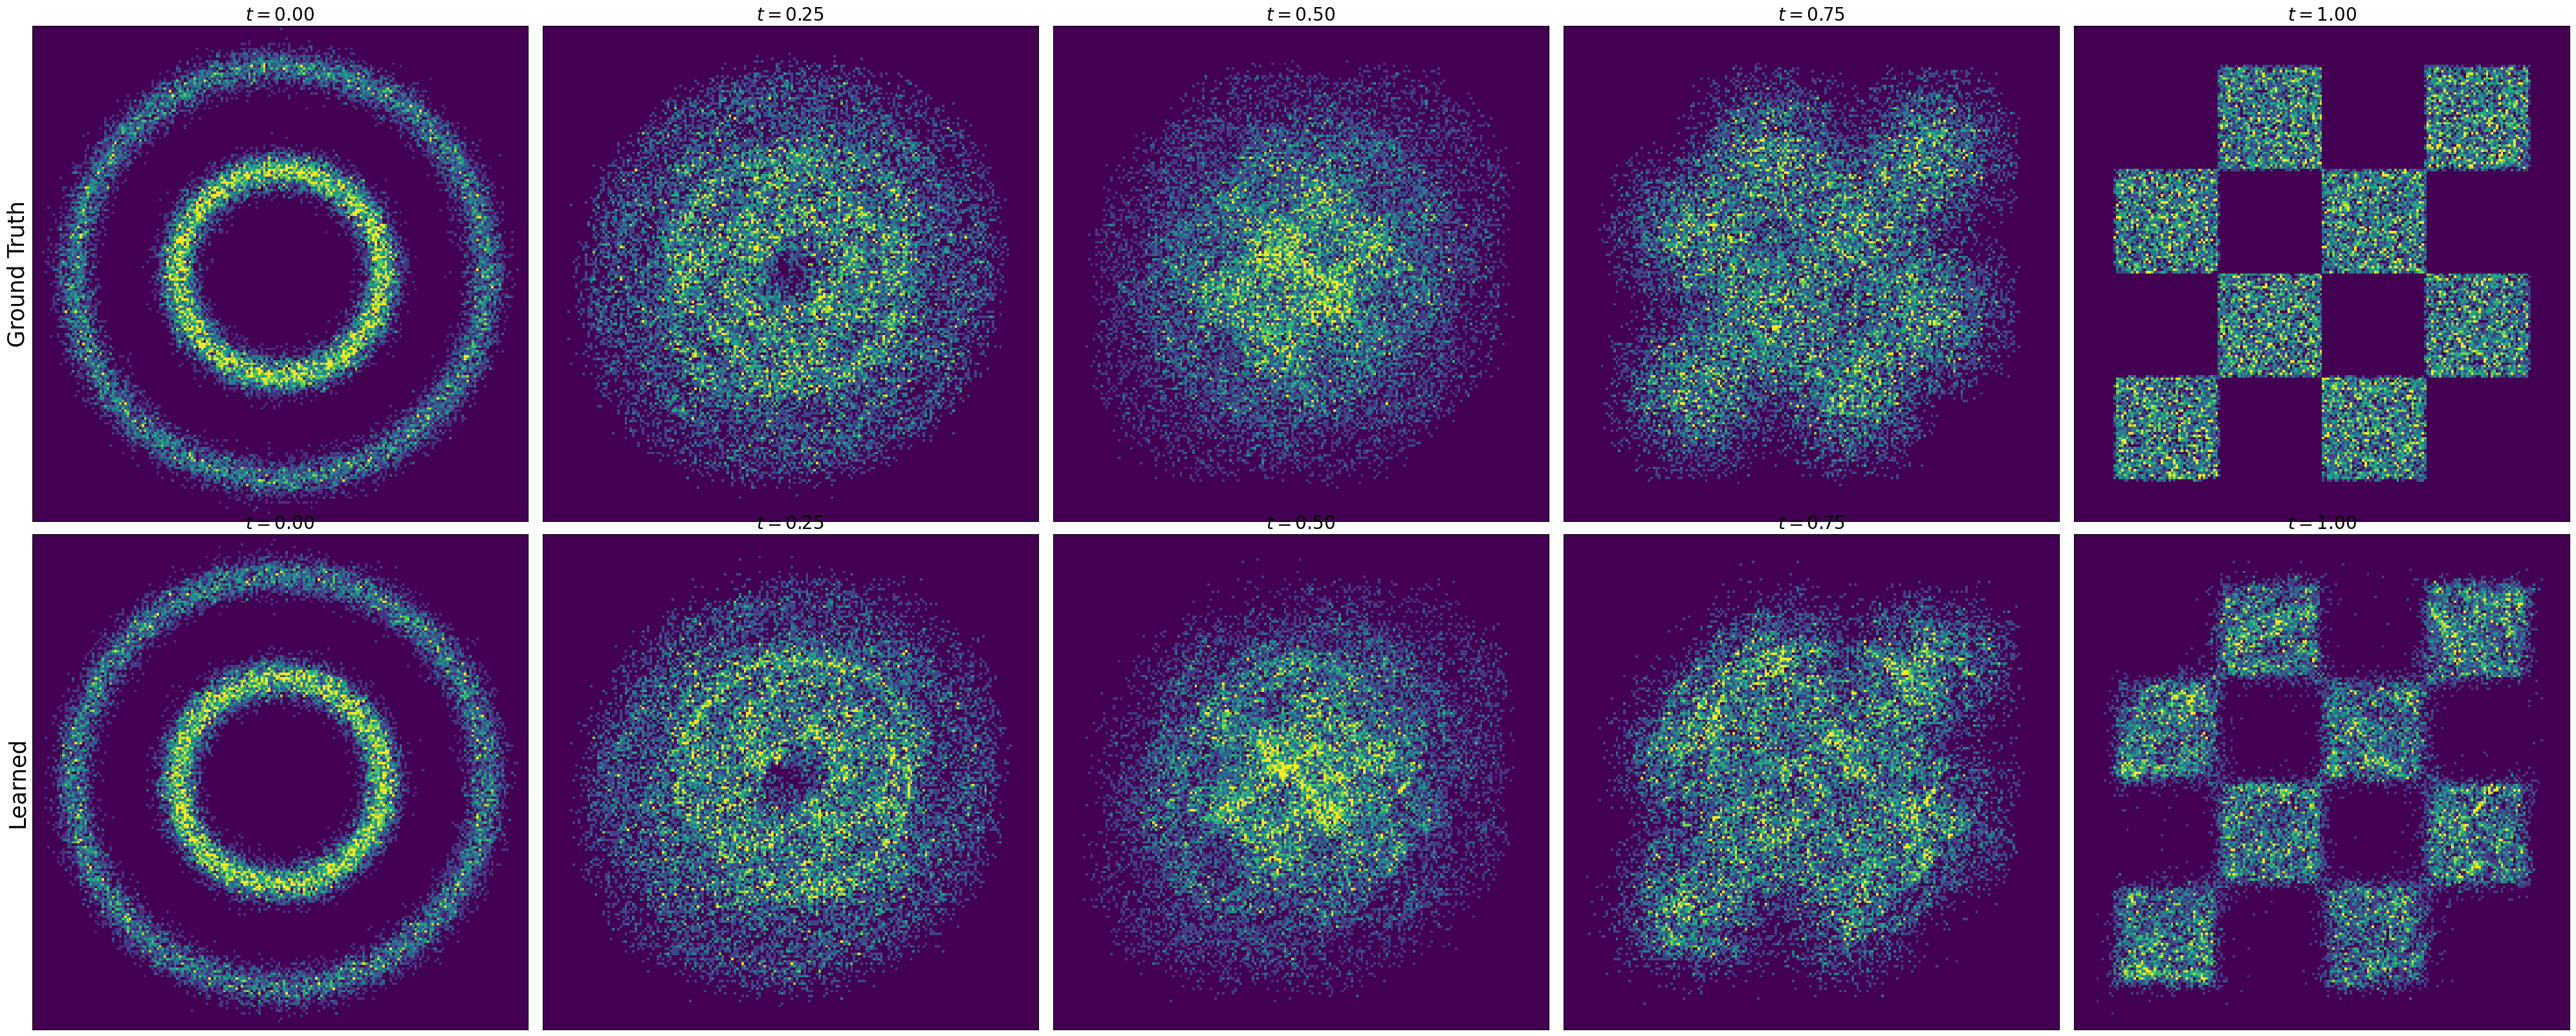

In [22]:
# Visualize bridging transformation
num_samples_bridge = 30000
num_timesteps_bridge = 200
num_marginals_bridge = 5
scale_bridge = 6.0

bridging_ode = LearnedVectorFieldODE(bridging_model)
bridging_simulator = EulerSimulator(bridging_ode)

x0_bridge = bridging_path.p_simple.sample(num_samples_bridge)
ts_bridge = torch.linspace(0.0, 1.0, num_timesteps_bridge, device=device)
traj_bridge = bridging_simulator.simulate_with_trajectory(x0_bridge, ts_bridge)

fig, axes = plt.subplots(2, num_marginals_bridge, figsize=(8 * num_marginals_bridge, 16))
indices_bridge = get_trajectory_snapshot_indices(num_timesteps_bridge, num_timesteps_bridge // (num_marginals_bridge - 1))

# Ground truth
axes[0, 0].set_ylabel("Ground Truth", fontsize=25)
for idx, time_idx in enumerate(indices_bridge):
    t_val = ts_bridge[time_idx]
    tt = repeat(t_val, ' -> b 1', b=num_samples_bridge)
    marginal_samples = bridging_path.sample_marginal_path(tt)
    ax = axes[0, idx]
    hist2d_samples(samples=marginal_samples.cpu(), ax=ax, bins=200, scale=scale_bridge, percentile=99, alpha=1.0)
    ax.set_xlim(-scale_bridge, scale_bridge)
    ax.set_ylim(-scale_bridge, scale_bridge)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'$t={t_val.item():.2f}$', fontsize=20)

# Learned
axes[1, 0].set_ylabel("Learned", fontsize=25)
for idx, time_idx in enumerate(indices_bridge):
    t_val = ts_bridge[time_idx]
    points = traj_bridge[:, time_idx, :]
    ax = axes[1, idx]
    hist2d_samples(samples=points.cpu(), ax=ax, bins=200, scale=scale_bridge, percentile=99, alpha=1.0)
    ax.set_xlim(-scale_bridge, scale_bridge)
    ax.set_ylim(-scale_bridge, scale_bridge)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'$t={t_val.item():.2f}$', fontsize=20)

plt.tight_layout()
plt.show()

## 10. Summary: Complete Pipeline

You now have a complete toolkit for flow and score matching:

**Flow Matching (CFM)**:
1. Train vector field $u_t^\theta(x)$
2. Visualize conditional path (fixed z)
3. Visualize marginal path (learned ODE)

**Score Matching (CSM)**:
4. Train score model $s_t^\theta(x)$
5. Visualize conditional SDE (ground-truth score + diffusion)
6. Visualize marginal SDE (Langevin Flow)
7. Derive scores from vector fields

**Flexibility**:
- **Gaussian paths**: $p_t(x|z) = \mathcal{N}(\alpha_t z, \beta_t^2 I)$
- **Linear paths**: $X_t = (1-t)X_0 + tz$
- **Bridging**: Transform any distribution to any other

The `sde_lib` abstractions make it easy to experiment with different configurations!